<a href="https://colab.research.google.com/github/AharonRemez/Emotion-Classification-Using-Convolutional-Neural-Networks-CNN-1/blob/main/Emotion_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset Download and Extraction:**

In [ ]:
!pip install kaggle
!kaggle datasets download -d sujaykapadnis/emotion-recognition-dataset
!unzip emotion-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Sad/0a12a7e998fa7abde73e79ce2a74477bdc6f5dd010da05231f4c3330.jpg  
  inflating: dataset/Sad/0a1370fc7e34586d5f134694c9d1e79ed4cce9e59684077ae5061db8.png  
  inflating: dataset/Sad/0a14abb2a25753914205e88e870054918de36219552002f3144b8455.jpg  
  inflating: dataset/Sad/0a15eede4e05e13f70f6540c4167282f9a488cc318005c8693c49433.jpg  
  inflating: dataset/Sad/0a163aa46984ad37b58aa6b8175dca9b1007a3066099d18f4dda6f78.jpg  
  inflating: dataset/Sad/0a1833eb2427bd8c1ddd3b9c020c6233a3671763e21b1e08b5afa41f.jpg  
  inflating: dataset/Sad/0a19842e87935fbd2c45a7042e4bb8d1d3816476e8a6b7e8f41205d8.jpg  
  inflating: dataset/Sad/0a1d613237e9af295213c61e1c2b9d7fd211fad638c522afb9548901.jpg  
  inflating: dataset/Sad/0a1d86074a08f9bf55858cf90eaaee6f1e0362d97f08cbaa161e30e0.jpg  
  inflating: dataset/Sad/0a22b8d3b2fbcbebb6a4be7dad0a37b92983e8afe42b4d48cded4e45.jpg  
  inflating: dataset/Sad/0a285a2a07f0f8daaa0a821e30ad2e558ddc18f2589a

**Library Imports:**

In [ ]:
import numpy as np
import PIL
import tensorflow as tf
from pathlib import Path
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Dataset Path Initialization and Class Name Extraction:**

In [ ]:
data_dir = Path('/content/dataset')
CLASS_NAMES = []

x = 0  # Initialize counter for total images
for expression in os.listdir(data_dir):
    # Create path to each expression folder
    expression_path = data_dir / expression
    print(f'{expression}\t=> {len(os.listdir(expression_path))} images')  # Print count of images per class
    x += len(os.listdir(expression_path))  # Increment total image counter
    CLASS_NAMES.append(expression)

print(f'Total Images: {x}')
print(f'Class Names: {CLASS_NAMES}')

Happy		=> 3740
Angry		=> 1313
Neutral		=> 4027
Sad		=> 3934
Surprise		=> 1234
Total Images : 14248
Class Image => ['Happy', 'Angry', 'Neutral', 'Sad', 'Surprise']


**Delete the Ahegao folder from the dataset for me:**

In [ ]:
!rm -rf /content/dataset/Ahegao

**Dataset Preparation and Splitting for Training and Validation:**

In [ ]:
CONFIGURATION = {
    'VALIDATION' : 0.2,
    'BATCH_SIZE' : 64,
    'IM_SIZE' : 224,
    'LEARNING_RATE' : 1e-3,
    'N_EPOCHS' : 50,
    'DROPOUT_RATE' : 0.25,
    'REGULARIZATION_RATE' : 0.01,
    'N_FILTERS' : 6,
    'KERNEL_SIZE' : 5,
    'N_STRIDES' : 1,
    'POOL_SIZE' : 2,
    'N_DENSE_1' : 128,
    'N_DENSE_2' : 32,
    'NUM_CLASSES' : len(CLASS_NAMES),
    'CLASS_NAMES' : CLASS_NAMES,
}

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CONFIGURATION['CLASS_NAMES'],
    color_mode = 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 100,
    subset = "training",
    validation_split = CONFIGURATION['VALIDATION']
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CONFIGURATION['CLASS_NAMES'],
    color_mode = 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 200,
    subset = "validation",
    validation_split = CONFIGURATION['VALIDATION']
)

Found 14248 files belonging to 5 classes.
Using 11399 files for training.
Found 14248 files belonging to 5 classes.
Using 2849 files for validation.


**Check the class names:**

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Happy', 'Angry', 'Neutral', 'Sad', 'Surprise']


**Batch Inspection:**

In [ ]:
for image_batch, labels_batch in train_ds:
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Labels batch shape: {labels_batch.shape}")
    break

(64, 224, 224, 3)
(64, 5)


**Dataset Caching and Prefetching:**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Model Definition - EfficientNetV2B0 Backbone:**

In [ ]:
backbone = tf.keras.applications.EfficientNetV2B0(
    input_shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3),
    include_top=False,
    weights='imagenet'
)
backbone.trainable = False  # Freeze the backbone layers

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │         313,605 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,232,917 (23.78 MB)

 Trainable params: 313,605 (1.20 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

**Model Construction:**

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)),
    backbone,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),  # Prevent overfitting
    tf.keras.layers.Dense(CONFIGURATION['NUM_CLASSES'], activation='softmax')  # Output layer
])

model.summary()


**Model Compilation and Training with Early Stopping and Checkpointing:**

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam


loss_func = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name = 'accuracy')]

checkpoint_callback = ModelCheckpoint(
    'best_weights.keras',  # Save the best model weights
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True  # Only save the best weights
)

# Define early stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy for early stopping
    restore_best_weights=True,  # Restore the best weights when stopping
    patience=3  # Number of epochs to wait before stopping if no improvement
)

model.compile(
    optimizer=Adam(learning_rate=1e-2),
    loss=loss_func,
    metrics=metrics
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIGURATION['N_EPOCHS'],  # Number of epochs
    verbose=1,  # Verbosity level for logging
    callbacks=[early_stopping]
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 167ms/step - accuracy: 0.8820 - loss: 10.3525 - val_accuracy: 0.9140 - val_loss: 10.1431
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.8885 - loss: 10.1357 - val_accuracy: 0.9245 - val_loss: 9.7249
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.8773 - loss: 10.9545 - val_accuracy: 0.9231 - val_loss: 10.6167
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.8923 - loss: 10.1648 - val_accuracy: 0.9172 - val_loss: 10.3650
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8927 - loss: 10.3668 - val_accuracy: 0.9221 - val_loss: 10.8729


**Display Sample Images with Predictions:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


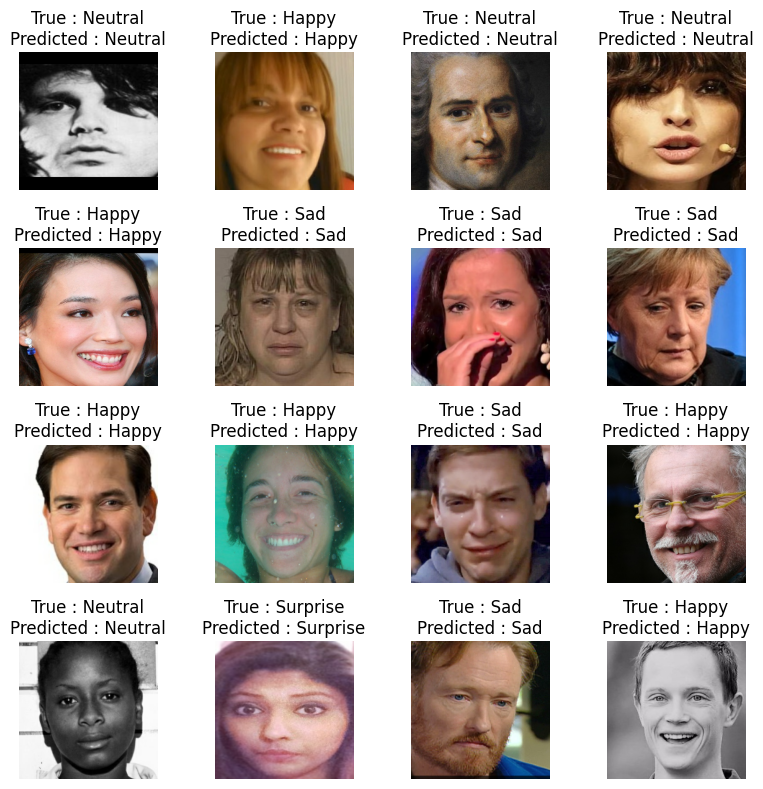

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for image_batch, label_batch in train_ds.take(1):
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i] / 255)
        true_label = CLASS_NAMES[tf.argmax(label_batch[i], axis=0).numpy()]
        predicted_label = CLASS_NAMES[tf.argmax(model.predict(tf.expand_dims(image_batch[i], axis=0)), axis=1).numpy()[0]]
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
        plt.axis('off')  # Remove axis
    plt.tight_layout()
    plt.show()

**Single Image Prediction from User Upload:**

Saving מאוכזב.jpg to מאוכזב.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
This image most likely belongs to Sad with a 40.46 percent confidence.


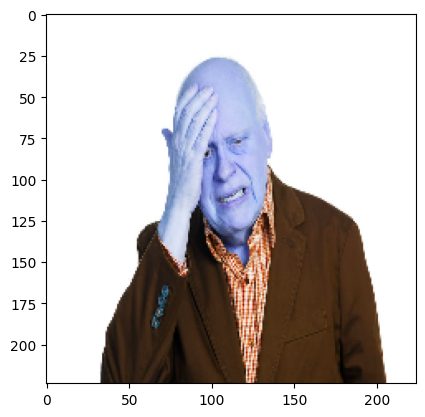

In [ ]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt

# Upload an image file
uploaded = files.upload()

# Loop through each uploaded file and predict the image class
for fn in uploaded.keys():
    path = '/content/' + fn
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))  # Resize image to model input size
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    plt.imshow(img)
    plt.show()

**Display Confusion Matrix:**

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━

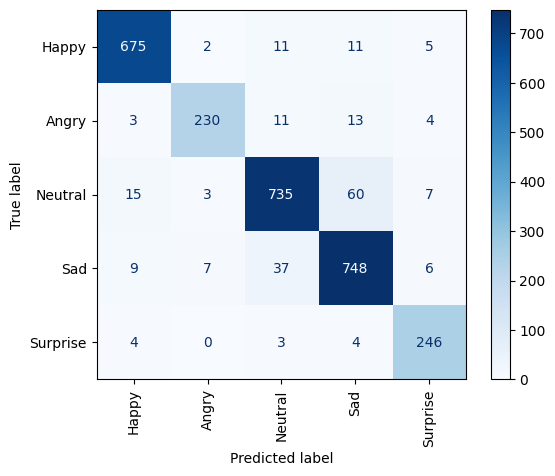

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Loop through the validation dataset and generate predictions
for images, labels in val_ds:
    predictions = model.predict(images)
    for i in range(images.shape[0]):
        y_true.append(np.argmax(labels[i]))
        y_pred.append(np.argmax(predictions[i]))

# Compute and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()
